In [1]:
import numpy as np
import pandas as pd
from utils import constants
from utils.utils import model_accuracy
import scikitplot as skplt

from tensorflow.keras.utils import load_img, img_to_array
from keras.models import load_model
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess_input


SMALL_TEST_DIRECTORY = "database/small_test/"

2022-11-25 13:29:01.037980: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
def load_image(img_path):

    img = load_img(img_path, target_size=(224, 224))
    img_tensor = img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    #img_tensor /= 255
    
    return img_tensor

In [3]:
class_names = ["basal","melanoma","squamous","misc"]
class_names = sorted(class_names) # Sorting them
name_id_map = dict(zip(range(len(class_names)),class_names))
id_name_map = dict(zip(class_names,range(len(class_names))))
print(name_id_map)
img_size = (224,224)
shape = (224,224,3)

{0: 'basal', 1: 'melanoma', 2: 'misc', 3: 'squamous'}


In [4]:
def print_predictions(predictions, name, files):
    for pred, file in zip(predictions, files):
        pred = np.array(pred)
        pred = np.round(pred,3) 
        cl = name_id_map[pred.argmax(axis=-1)]
        print('Model: ', name, "File: ", file, " Class predicted: ", str.capitalize(cl), " Predictions: ", pred )

# Load Models


In [6]:
efficient = load_model('EfficientNet.h5')
resnet = load_model("ResNet.h5")
vgg = load_model("VGG16.h5")

## VGG

In [7]:
vgg_datagen = ImageDataGenerator(preprocessing_function = vgg_preprocess_input)
vgg_generator = vgg_datagen.flow_from_directory(
                    constants.TEST_DIRECTORY,
                    target_size=img_size,
                    batch_size=1,
                    class_mode='categorical',
                    shuffle = False)  

Found 742 images belonging to 4 classes.


## ResNet

In [8]:
resnet_datagen = ImageDataGenerator(preprocessing_function = resnet_preprocess_input)
resnet_generator = resnet_datagen.flow_from_directory(
                    constants.TEST_DIRECTORY,
                    target_size=img_size,
                    batch_size=1,
                    class_mode='categorical',
                    shuffle = False)  

Found 742 images belonging to 4 classes.


## EfficientNet

In [9]:
efficient_datagen = ImageDataGenerator()
efficient_generator = efficient_datagen.flow_from_directory(
                    constants.TEST_DIRECTORY,
                    target_size=img_size,
                    batch_size=1,
                    class_mode='categorical',
                    shuffle = False)  

Found 742 images belonging to 4 classes.


# Fusion Strategies

In [10]:
def sum_of_probabilities(vgg_prediction, resnet_prediction, eff_prediction):
    total_sum = 0
    predictions = np.zeros(len(vgg_prediction))
    
    for i in range(len(vgg_prediction)):
        s = vgg_prediction[i] + resnet_prediction[i] + eff_prediction[i]
        predictions[i] = s
        total_sum += s
    predictions = np.array(predictions)
    predictions /= total_sum
    return predictions

In [11]:
def product_of_probabilities(vgg_prediction, resnet_prediction, eff_prediction):
    total_sum = 0
    predictions = np.zeros(len(vgg_prediction))
    for i in range(len(vgg_prediction)):
        s = vgg_prediction[i] * resnet_prediction[i] * eff_prediction[i]
        predictions[i] = s
        total_sum += s
    predictions = np.array(predictions)
    predictions /= total_sum
    return predictions

In [12]:
def sum_of_maximum_probabilities(vgg_prediction, resnet_prediction, eff_prediction):
    total_sum = 0
    predictions = np.zeros(len(vgg_prediction))

    max_vgg = np.argmax(vgg_prediction)
    max_resnet = np.argmax(resnet_prediction)
    max_effnet = np.argmax(eff_prediction)

    for i in range(len(vgg_prediction)):
        s = vgg_prediction[i] + resnet_prediction[i] + eff_prediction[i]
        r = resnet_prediction[i] if resnet_prediction[i] == max_resnet else 0
        e = eff_prediction[i] if eff_prediction[i] == max_effnet else 0
        predictions[i] = v + r + e
        total_sum += v + r + e
    predictions = np.array(predictions)
    predictions /= total_sum
    return predictions

In [13]:
def average(vgg_prediction, resnet_prediction, eff_prediction):
    predictions = np.zeros((len(vgg_prediction),len(vgg_prediction[0])))
    
    for j in range(len(vgg_prediction)):
        for i in range(len(vgg_prediction[0])):
            s = vgg_prediction[j][i] + resnet_prediction[j][i] + eff_prediction[j][i]
            predictions[j][i] = s / 3
    predictions = np.array(predictions)
    return predictions

In [14]:
def certainty_average_method(vgg_prediction, resnet_prediction, eff_prediction):
    predictions = np.zeros((len(vgg_prediction),len(vgg_prediction[0])))

    vgg_certainty = [[item if item > 0.5 else (1 - item)  for item in row]for row in vgg_prediction]
    resnet_certainty = [[item if item > 0.7 else (1 - item) for item in row] for row in resnet_prediction]
    eff_certainty = [[item if item > 0.5 else (1 - item) for item in row] for row in eff_prediction]

    for j in range(len(vgg_prediction)):
        for i in range(len(vgg_prediction[0])):
            w_normalization = vgg_certainty[j][i] + resnet_certainty[j][i] + eff_certainty[j][i]
            w_normalization = w_normalization if w_normalization > 0 else 1
            predictions[j][i] = (vgg_certainty[j][i] / w_normalization) * vgg_prediction[j][i]
            predictions[j][i] += (resnet_certainty[j][i] / w_normalization) * resnet_prediction[j][i]
            predictions[j][i] += (eff_certainty[j][i] / w_normalization) * eff_prediction[j][i]

    predictions = np.array(predictions)
    return predictions

In [15]:
def threshold_certainty_average_method(vgg_prediction, resnet_prediction, eff_prediction):
    predictions = np.zeros((len(vgg_prediction),len(vgg_prediction[0])))

    vgg_certainty = [[item if item > 0.5 else (1 - item)  if item < 0.3 else 0  for item in row]for row in vgg_prediction]
    resnet_certainty = [[item if item > 0.7 else (1 - item) if item < 0.3 else 0 for item in row] for row in resnet_prediction]
    eff_certainty = [[item if item > 0.5 else (1 - item) if item < 0.3 else 0 for item in row] for row in eff_prediction]

    for j in range(len(vgg_prediction)):
        for i in range(len(vgg_prediction[0])):
            w_normalization = vgg_certainty[j][i] + resnet_certainty[j][i] + eff_certainty[j][i]
            w_normalization = w_normalization if w_normalization > 0 else 1
            predictions[j][i] = (vgg_certainty[j][i] / w_normalization) * vgg_prediction[j][i]
            predictions[j][i] += (resnet_certainty[j][i] / w_normalization) * resnet_prediction[j][i]
            predictions[j][i] += (eff_certainty[j][i] / w_normalization) * eff_prediction[j][i]

    predictions = np.array(predictions)
    return predictions

# Ensemble

In [16]:
def predict_images(models, generators, fusion_strategy, weights = None):

    predictions = []

    for model, generator in zip(models, generators):
        model_predictions = model.predict(generator)
        predictions.append(model_predictions)
    
    if weights:
        predictions[0] = np.array(predictions[0]) * weights[0]
        predictions[1] = np.array(predictions[1]) * weights[1]
        predictions[2] = np.array(predictions[2]) * weights[2]

    ensemble = fusion_strategy(predictions[0], predictions[1], predictions[2])

    filenames = generators[2].filenames
    true_labels = []
    predicted_labels = []
    true_predictions = []
    temp = np.zeros(4)

    for (prediction, file) in zip(ensemble, filenames):
        label = np.argmax(prediction, axis = -1)
        true_label = file.split('/')[0]
        true_labels.append(true_label)
        predicted_labels.append(name_id_map[label])
        temp[label] = 1
        true_predictions.append(temp)
        temp = np.zeros(4)

    return ensemble, true_labels, predicted_labels, true_predictions, predictions

# Average

In [66]:
predictions, true_labels, predicted_labels, true_predictions, all_predictions = predict_images(models=[vgg,resnet,efficient],
                                                                              generators= [vgg_generator,resnet_generator,efficient_generator],
                                                                              fusion_strategy=average)

742/742 [==============================] - 16s 20ms/step


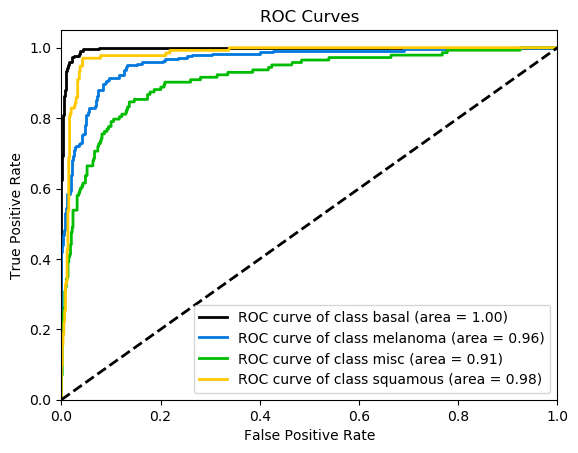

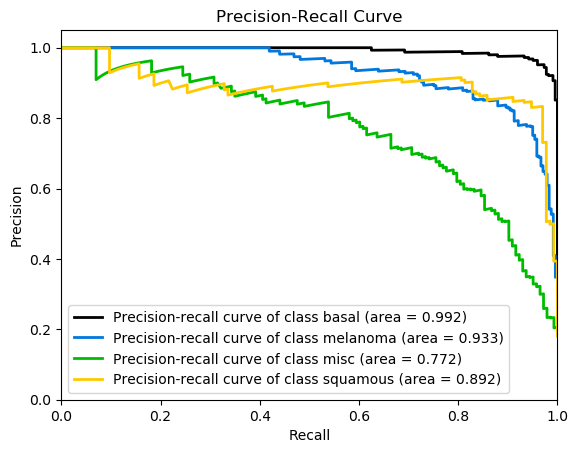

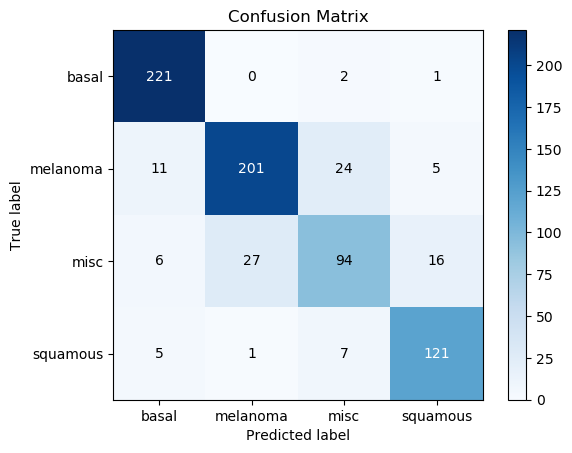

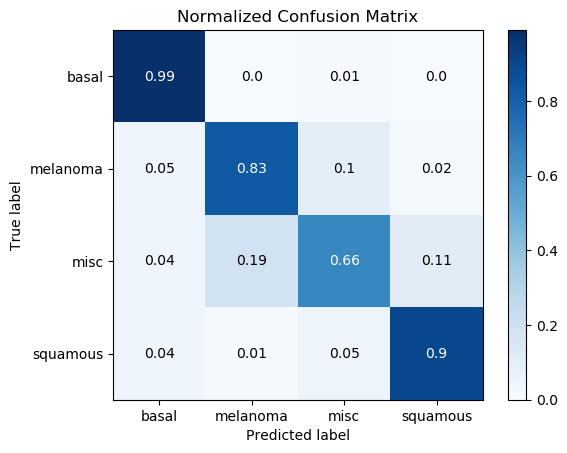

In [31]:
y_train = np.array([id_name_map[item] for item in true_labels])
skplt.metrics.plot_roc(true_labels, predictions, plot_micro= False, plot_macro=False)
skplt.metrics.plot_precision_recall(true_labels, predictions, plot_micro=False)
skplt.metrics.plot_confusion_matrix(true_labels, predicted_labels)
skplt.metrics.plot_confusion_matrix(true_labels, predicted_labels, normalize=True)

In [67]:
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

       basal       0.92      0.99      0.95       224
    melanoma       0.88      0.85      0.87       241
        misc       0.77      0.67      0.72       143
    squamous       0.86      0.93      0.89       134

    accuracy                           0.87       742
   macro avg       0.86      0.86      0.86       742
weighted avg       0.87      0.87      0.87       742



# Average with Accuracy Weights

In [68]:
weights = [model_accuracy("VGG16"), model_accuracy("ResNet"), model_accuracy("EfficientNet")]
predictions, true_labels, predicted_labels, true_predictions, all_predictions = predict_images(models=[vgg,resnet,efficient],
                                                                              generators= [vgg_generator,resnet_generator,efficient_generator],
                                                                              fusion_strategy=average, weights=weights)

742/742 [==============================] - 16s 22ms/step


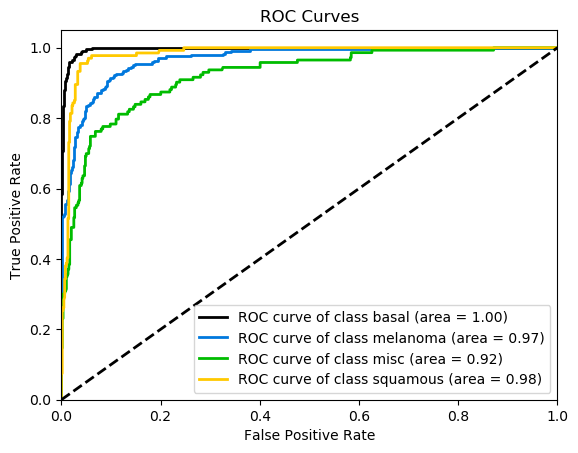

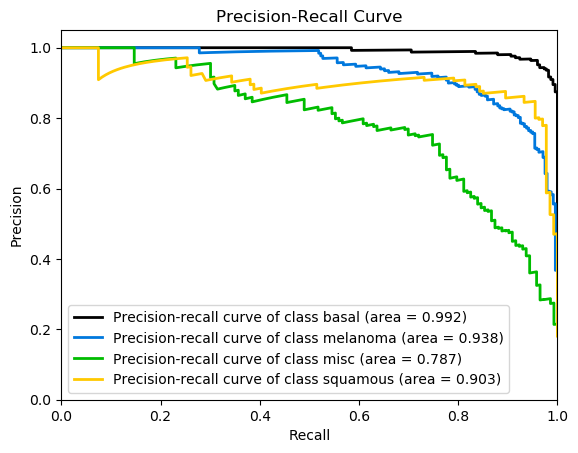

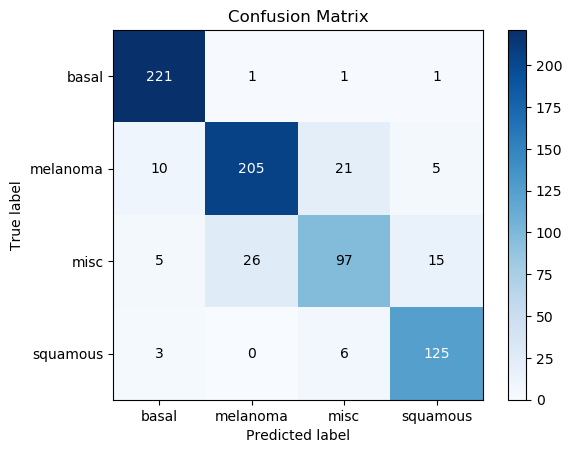

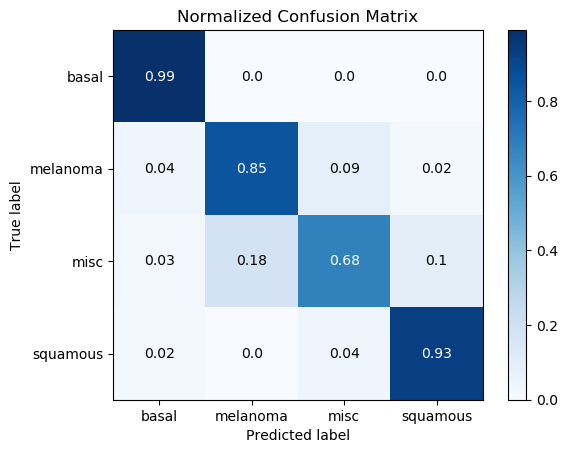

In [69]:
y_train = np.array([id_name_map[item] for item in true_labels])
skplt.metrics.plot_roc(true_labels, predictions, plot_micro= False, plot_macro=False)
skplt.metrics.plot_precision_recall(true_labels, predictions, plot_micro=False)
skplt.metrics.plot_confusion_matrix(true_labels, predicted_labels)
skplt.metrics.plot_confusion_matrix(true_labels, predicted_labels, normalize=True)

In [70]:
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

       basal       0.92      0.99      0.95       224
    melanoma       0.88      0.85      0.87       241
        misc       0.78      0.68      0.72       143
    squamous       0.86      0.93      0.89       134

    accuracy                           0.87       742
   macro avg       0.86      0.86      0.86       742
weighted avg       0.87      0.87      0.87       742



# Average with rank

In [71]:
weights = [2/6, 1/6, 3/6]
predictions, true_labels, predicted_labels, true_predictions, all_predictions = predict_images(models=[vgg,resnet,efficient],
                                                                              generators= [vgg_generator,resnet_generator,efficient_generator],
                                                                              fusion_strategy=average, weights=weights)


742/742 [==============================] - 15s 21ms/step


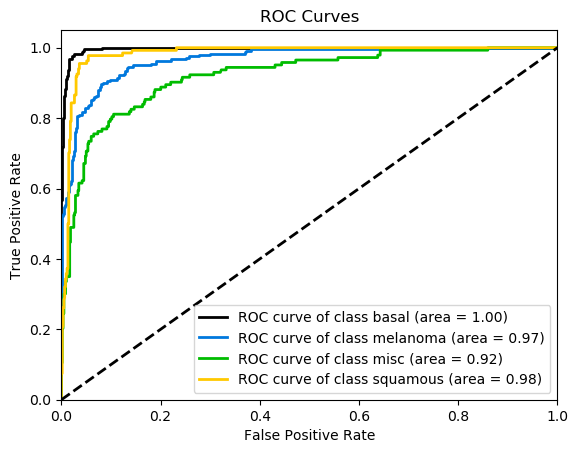

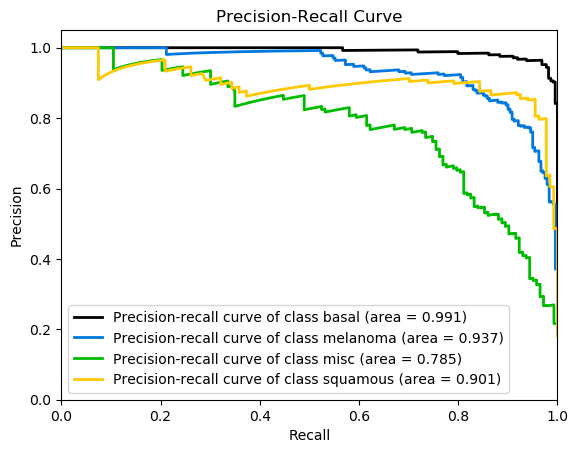

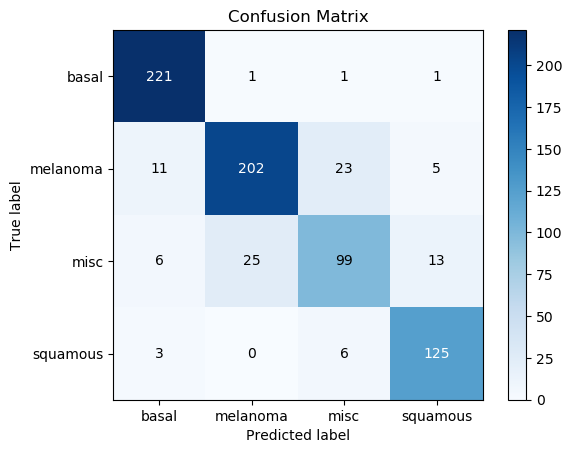

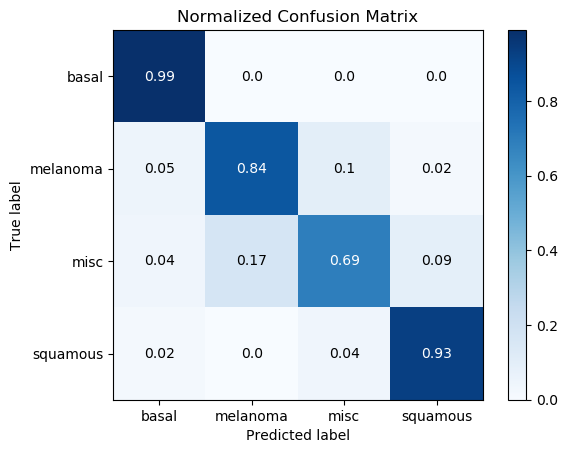

In [72]:
y_train = np.array([id_name_map[item] for item in true_labels])
skplt.metrics.plot_roc(true_labels, predictions, plot_micro= False, plot_macro=False)
skplt.metrics.plot_precision_recall(true_labels, predictions, plot_micro=False)
skplt.metrics.plot_confusion_matrix(true_labels, predicted_labels)
skplt.metrics.plot_confusion_matrix(true_labels, predicted_labels, normalize=True)

In [73]:
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

       basal       0.92      0.99      0.95       224
    melanoma       0.89      0.84      0.86       241
        misc       0.77      0.69      0.73       143
    squamous       0.87      0.93      0.90       134

    accuracy                           0.87       742
   macro avg       0.86      0.86      0.86       742
weighted avg       0.87      0.87      0.87       742



# Certainty 

In [74]:
predictions, true_labels, predicted_labels, true_predictions, all_predictions = predict_images(models=[vgg,resnet,efficient],
                                                                              generators= [vgg_generator,resnet_generator,efficient_generator],
                                                                              fusion_strategy=certainty_average_method)

742/742 [==============================] - 16s 21ms/step


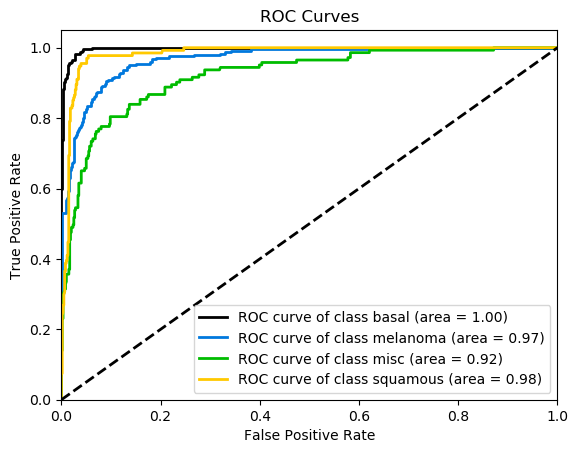

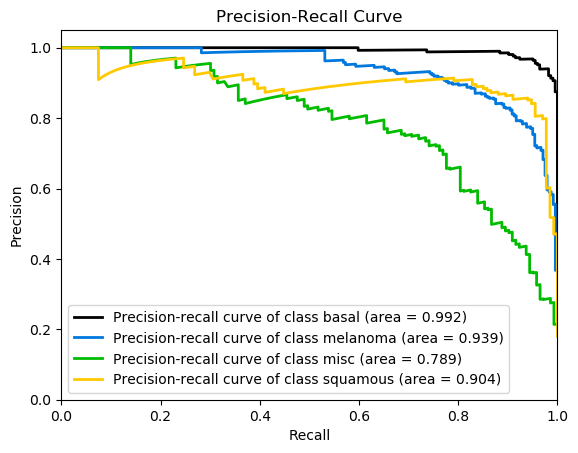

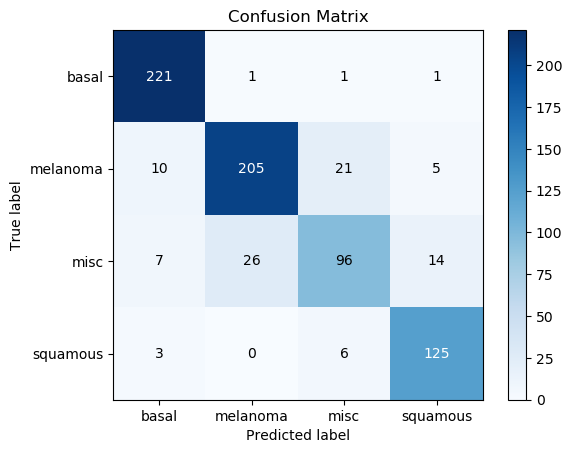

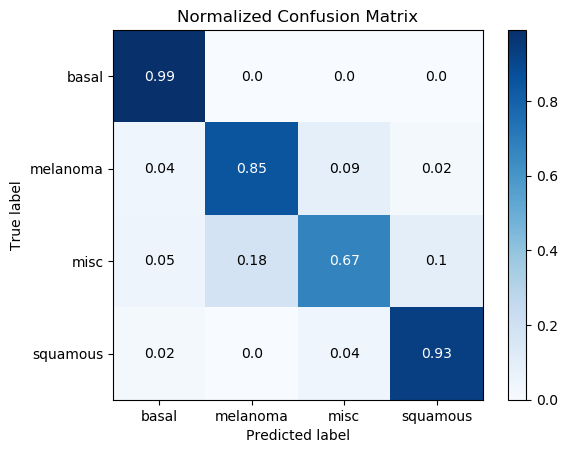

In [75]:
y_train = np.array([id_name_map[item] for item in true_labels])
skplt.metrics.plot_roc(true_labels, predictions, plot_micro= False, plot_macro=False)
skplt.metrics.plot_precision_recall(true_labels, predictions, plot_micro=False)
skplt.metrics.plot_confusion_matrix(true_labels, predicted_labels)
skplt.metrics.plot_confusion_matrix(true_labels, predicted_labels, normalize = True)

In [76]:
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

       basal       0.92      0.99      0.95       224
    melanoma       0.88      0.85      0.87       241
        misc       0.77      0.67      0.72       143
    squamous       0.86      0.93      0.90       134

    accuracy                           0.87       742
   macro avg       0.86      0.86      0.86       742
weighted avg       0.87      0.87      0.87       742



# Threshold certainty

In [17]:
predictions, true_labels, predicted_labels, true_predictions, all_predictions = predict_images(models=[vgg,resnet,efficient],
                                                                              generators= [vgg_generator,resnet_generator,efficient_generator],
                                                                              fusion_strategy=threshold_certainty_average_method)

2022-11-25 13:29:37.669695: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500
2022-11-25 13:29:38.543946: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-25 13:29:38.916129: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.06GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-11-25 13:29:38.916184: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.06GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-11-25 13:29:38.983537: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to al

  4/742 [..............................] - ETA: 30s  

2022-11-25 13:29:39.246956: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


742/742 [==============================] - 16s 20ms/step


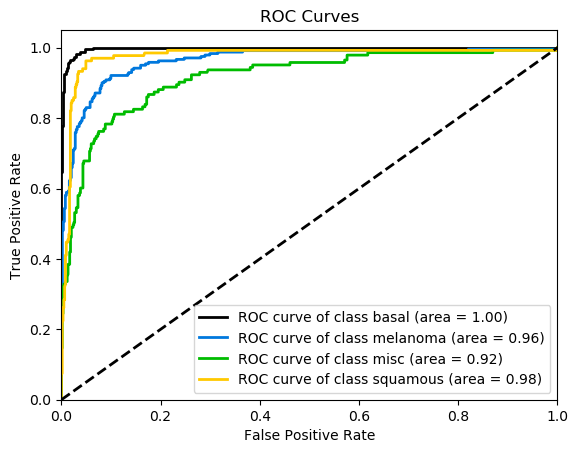

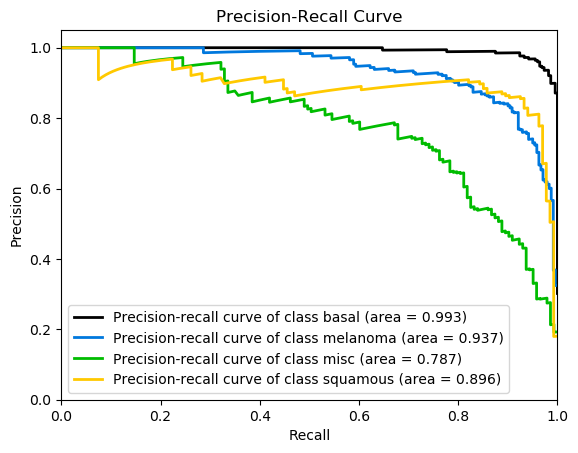

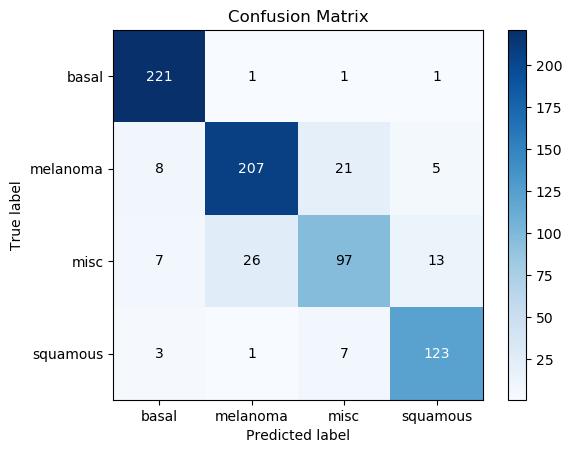

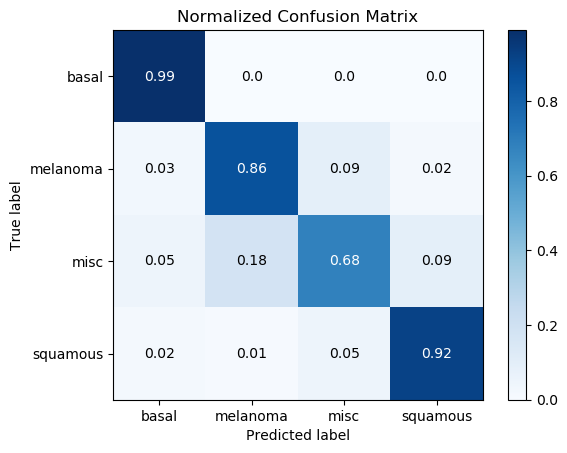

In [18]:
y_train = np.array([id_name_map[item] for item in true_labels])
skplt.metrics.plot_roc(true_labels, predictions, plot_micro= False, plot_macro=False)
skplt.metrics.plot_precision_recall(true_labels, predictions, plot_micro=False)
skplt.metrics.plot_confusion_matrix(true_labels, predicted_labels)
skplt.metrics.plot_confusion_matrix(true_labels, predicted_labels, normalize = True)

In [19]:
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

       basal       0.92      0.99      0.95       224
    melanoma       0.88      0.86      0.87       241
        misc       0.77      0.68      0.72       143
    squamous       0.87      0.92      0.89       134

    accuracy                           0.87       742
   macro avg       0.86      0.86      0.86       742
weighted avg       0.87      0.87      0.87       742



# Table with all predictions

In [20]:
def pandas_dataframe(files, true_prediction, ensemble_prediction, vgg_prediction, resnet_prediction, eff_prediction):

    def format_prediction(predictions):
        response = []
        for pred in predictions:
            pred = np.array(pred)
            pred = np.round(pred,3) 
            percent = pred[pred.argmax(axis=-1)]
            cl = name_id_map[pred.argmax(axis=-1)]  
            response.append(str.capitalize(cl) + "-" + str(percent) + "%")
        return response

    d = {"Ficheros": files, "Prediccion Correcta": true_prediction, "Ensemble": format_prediction(ensemble_prediction), 
    "VGG16": format_prediction(vgg_prediction), "ResNet50": format_prediction(resnet_prediction),
    "EfficientB0": format_prediction(eff_prediction)}
    
    return pd.DataFrame(data=d)

df = pandas_dataframe(efficient_generator.filenames, true_labels, predictions, all_predictions[0], all_predictions[1], all_predictions[2])
df.to_csv("output.csv", index= False) 


# Predict Image

In [38]:
def print_predictions(models, preprocess_function, fusion_strategy, img_path, weights = None):
    predictions = []
    for m, fun in zip(models, preprocess_function):
        img = load_image(img_path)
        img = fun(img)
        pred = m.predict(img, verbose = 0)
        predictions.append(pred)
        
        pred = np.array(pred)
        pred = np.round(pred,3) 
        name = name_id_map[pred.argmax(1)[0]]
        print('Model: ',m.name," Class predicted: ", str.capitalize(name), " Predictions: ", pred)
    
    if weights:
        predictions = [item * w for item, w in zip(predictions,weights)]
        
    ens = fusion_strategy(predictions[0], predictions[1], predictions[2])
    ens = np.round(np.array(ens),3)
    name = name_id_map[ens.argmax(1)[0]]
    print('Model: Ensemble'," Class predicted: ", str.capitalize(name), " Predictions: ", ens)


In [50]:
print_predictions([vgg,resnet,efficient],[vgg_preprocess_input,resnet_preprocess_input,lambda x : x],
                    threshold_certainty_average_method, img_path = 'database/misc_images/ISIC_0030757.png')

Model:  VGG16  Class predicted:  Misc  Predictions:  [[0.011 0.002 0.983 0.004]]
Model:  model  Class predicted:  Squamous  Predictions:  [[0.055 0.011 0.226 0.709]]
Model:  EfficientNet  Class predicted:  Squamous  Predictions:  [[0.317 0.069 0.123 0.49 ]]
Model: Ensemble  Class predicted:  Misc  Predictions:  [[0.032 0.027 0.474 0.298]]


In [52]:

print_predictions([vgg,resnet,efficient],[vgg_preprocess_input,resnet_preprocess_input, lambda x : x],
                    average, 'database/misc_images/ISIC_0030757.png', [0.1,0.3,0.5])

Model:  VGG16  Class predicted:  Misc  Predictions:  [[0.011 0.002 0.983 0.004]]
Model:  model  Class predicted:  Squamous  Predictions:  [[0.055 0.011 0.226 0.709]]
Model:  EfficientNet  Class predicted:  Squamous  Predictions:  [[0.317 0.069 0.123 0.49 ]]
Model: Ensemble  Class predicted:  Squamous  Predictions:  [[0.059 0.013 0.076 0.153]]
